In [22]:
# Imported Libraries
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import accuracy_score

In [2]:
df_all = pd.read_csv(r'data/Real_Final_F.csv', low_memory=False)
df_new = df_all.copy()

In [3]:
df_new = df_new.drop(['TDF'], axis=1)
df_new = df_new.drop(['Racks'], axis=1)
df_new = df_new.drop(['Time'], axis=1)

In [4]:
df_new.columns

Index(['Tmp', 'TmpMax', 'TmpMin', 'VCell', 'VCellMax', 'VCellMin', 'A',
       'AChaMax', 'ADisChaMax', 'SoC', 'W', 'WChaMax', 'WDisChaMax', 'TDW'],
      dtype='object')

In [5]:
for i in df_new.columns:
    print(i,":" ,df_new[f'{i}'].isnull().sum())

Tmp : 0
TmpMax : 0
TmpMin : 0
VCell : 0
VCellMax : 0
VCellMin : 0
A : 0
AChaMax : 0
ADisChaMax : 0
SoC : 0
W : 0
WChaMax : 0
WDisChaMax : 0
TDW : 0


In [6]:
df_new.shape

(4741572, 14)

### 극명하게 나타나는 불균형

<AxesSubplot:>

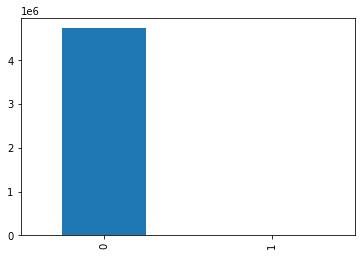

In [7]:
df_new.iloc[:, -1].value_counts().plot(kind='bar')

In [8]:
df_new.iloc[:, -1].value_counts() ## warring event의 갯수가 많이 적음

0    4734755
1       6817
Name: TDW, dtype: int64

In [9]:
df_new.iloc[:, -1].value_counts() / df_new.iloc[:, -1].count() * 100 ## 백분율로 분포 비율 확인

0    99.856229
1     0.143771
Name: TDW, dtype: float64

### normal dataset에서 20451개 가져오기

In [10]:
df_new_0 = df_new[df_new['TDW'] == 0]
df_new_1 = df_new[df_new['TDW'] == 1]

In [11]:
df_new_0 = df_new_0.sample(n=len(df_new_1) * 3, replace=True)

In [12]:
df_sample = pd.concat([df_new_0, df_new_1])

### train_test_split

In [13]:
X = df_sample.iloc[:, :-1]
y = df_sample.iloc[:, -1]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [15]:
## train, test 의 y값 나눠진 비율 확인
print(y_train.value_counts() / y_train.count() * 100)
print(y_test.value_counts() / y_test.count() * 100)

0    75.297323
1    24.702677
Name: TDW, dtype: float64
0    74.30632
1    25.69368
Name: TDW, dtype: float64


### make model

In [16]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred, average='macro')
    print('정확도 : {0: .2f},  정밀도 : {1: .2f}, 재현율 : {2: .2f}' .format(accuracy, precision, recall))
    print('f1_score : {0: .2f}, acu : {1: .2f}' .format(f1, roc_score))

In [17]:
# 평가 과정 함수화
def modeling(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    metrics(y_test, pred)

In [18]:
print("================== LogisticRegression ========================")
lr = LogisticRegression()
modeling(lr, X_train, X_test, y_train, y_test)
print("================== LGBMClassifier ========================")
lgb = LGBMClassifier(n_estimators=100, learning_rate=0.01, max_depth=2)
modeling(lgb, X_train, X_test, y_train, y_test)

================== LogisticRegression ========================
정확도 :  0.88,  정밀도 :  0.97, 재현율 :  0.55
f1_score :  0.70, acu :  0.77
================== LGBMClassifier ========================
정확도 :  0.94,  정밀도 :  0.94, 재현율 :  0.82
f1_score :  0.88, acu :  0.90


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

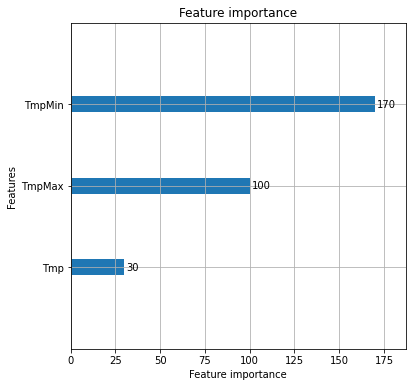

In [26]:
# 특성 중요도 시각화
import seaborn as sns
f, ax = plt.subplots(figsize=(6,6))
plot_importance(lgb,max_num_features=10, ax=ax) # 상위 10개를 조회 했는데도 정확히 온도의 칼럼만 나옴

In [ ]:
# print("================== LogisticRegression ========================")
# lr = LogisticRegression()
# modeling(lr, X_train, X_test, y_train, y_test)
# print("================== LGBMClassifier ========================")
# lgb = LGBMClassifier(n_estimators=400, num_leaves=80, n_jobs=-1,max_depth=7, boost_from_average=False)
# modeling(lgb, X_train, X_test, y_train, y_test)

### next step 일단 columns별 정규화 할 것으로 예상